In [1]:
import numpy as np
import jax.numpy as jnp
from pathlib import Path
from importlib import reload

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# figure aesthetics
plt.style.use(["../utils/dark.mplstyle","../utils/notebook.mplstyle"])  # for dark themes
# plt.style.use(['seaborn-notebook'])

In [3]:
# custom libraries
import sys, os

sys.path.append(os.path.abspath('../../spaths'))
import spaths

sys.path.append(os.path.abspath('..'))
from utils import dmaps

In [125]:
def slow_proj(data, sde, nreps, tspan, dt):
    nsam, ndim = data.shape
    ens0 = np.repeat(data, nreps, axis=0)
    nsteps = int(tspan[1]/dt)
    bursts = em.burst(sde, ens0, (0, nsteps), dt).reshape(nsam, nreps, ndim)
    return np.nanmean(bursts, axis=1)

# Hidden linear system

In [116]:
eps = .001

# underlying linear process coefficients
def drift_lin(t, u, du):
    du[0] = 1.0
    du[1] = (u[0] - u[1]) / eps

def dispersion_lin(t, u, du):
    du[0,0] = 1.0 / np.sqrt(100.0)
    du[1,1] = (1.5*u[0]-u[1]) / np.sqrt(3*eps)

sde_lin = spaths.ItoSDE(drift_lin, dispersion_lin, noise_mixing_dim=2)

In [117]:
# A = np.array(
#     [[0.0, 0.0],
#      [1.0, -1.0]]
# )
# # TODO: add linear SDEs to spaths

# B = np.array(
#     [[0.01, 0.0],
#      [0.0,  1.0]]
# )
# sde_ou = spaths.OrnsteinUhlenbeck(A, B)

In [118]:
# seed setting and solver
seed = 3579
rng = np.random.default_rng(seed)
rng.integers(10**3);  # warm up of RNG

# stochastic solver
em = spaths.EulerMaruyama(rng)

In [119]:
# simulation params
dt = eps / 5
x0, y0 = 3.0, 3.0
tspan = (0.0, 8.0)

In [120]:
ens0 = np.array([[x0,y0]]) #spaths.make_ens(x0, y0)
sol_lin = em.solve(sde_lin, ens0, tspan, dt)

In [121]:
sol_lin.p.shape

(1, 40001, 2)

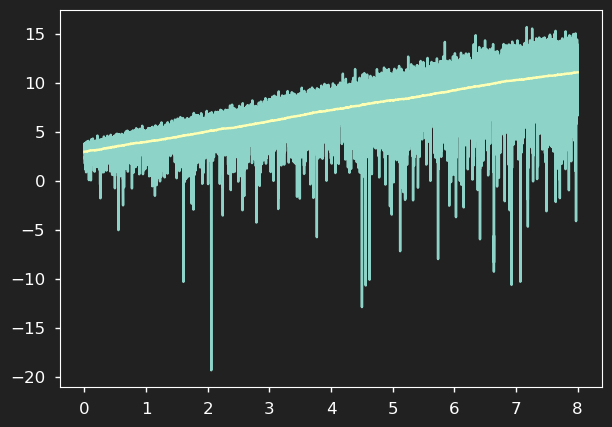

In [122]:
path = sol_lin.p[0]
plt.plot(sol_lin.t, path.T[1])
plt.plot(sol_lin.t, path.T[0]);

## Data from linear system

In [123]:
data = path[1::10].astype(np.float32)
print(f"{data.shape = }")
print(f"{data.dtype = }")

data.shape = (4000, 2)
data.dtype = dtype('float32')


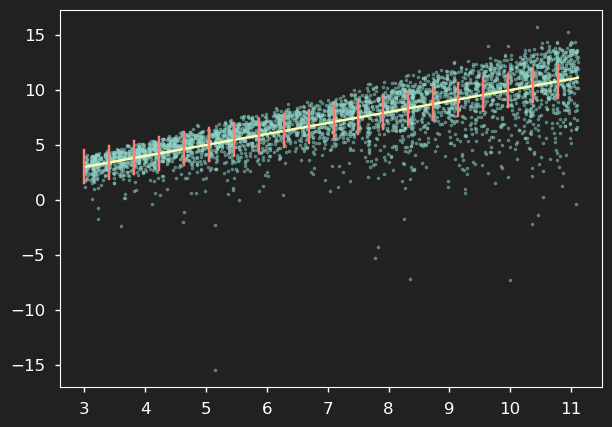

In [136]:
# plt.figure(figsize=(10,7))
plt.scatter(*data.T, s=5, alpha=0.5);
u = np.linspace(min(data.T[0]), max(data.T[0]), 100)
plt.plot(u, u, c='C1');
for u0 in u[::5]:
    u = 50*[u0]
    v = np.linspace(u0-1.5, u0+1.5, 50)
    plt.plot(u, v, color='C3');

## Slow projection

In [141]:
sp = slow_proj(data, sde_lin, 550, (0, 5*eps), dt/2)
sp.shape

(4000, 2)

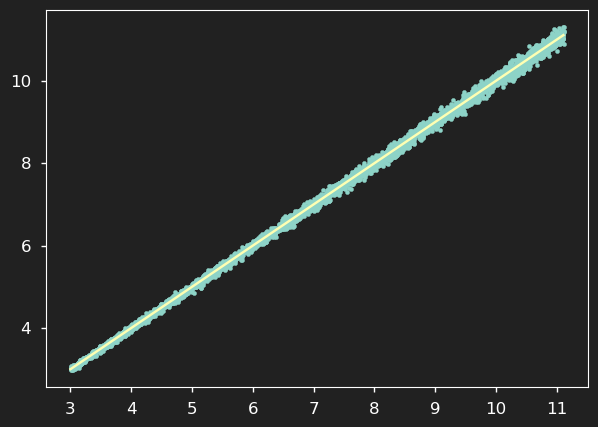

In [142]:
plt.scatter(*sp.T)
u = np.linspace(min(data.T[0]), max(data.T[0]), 100)
plt.plot(u, u, c='C1');

# Observed data & system

## Transformation of data

In [13]:
# helper functions
f = lambda r: jnp.sin(.2*np.pi*r) #jnp.log(1 + r**2)
# g = lambda r: r**3 / (1 + r**2)
th = 3.0
g = lambda r: r #th*jnp.log(r+th) #jnp.sin(.9 * r)
h = lambda s: s #jnp.exp(s/th)-th #2 * jnp.arcsin(s)

In [14]:
# transformation and its inverse
F = lambda u, v: (v, f(v) + g(u-v))
G = lambda x, y: (h(y-f(x)) + x, x)

In [15]:
# array verions
fwdF = lambda uv: jnp.array(F(uv[0], uv[1]))
bwdF = lambda xy: jnp.array(G(xy[0], xy[1]))

In [16]:
np.allclose(bwdF(fwdF(data.T)), data.T)

True

In [17]:
Fdata = fwdF(data.T).T
# Fdata = rng.permutation(Fdata)  # results do not depend on time relation

In [18]:
print(f"{Fdata.shape = }")
print(f"{Fdata.dtype = }")

Fdata.shape = (4000, 2)
Fdata.dtype = dtype('float32')


In [19]:
np.allclose(fwdF(bwdF(Fdata.T)), Fdata.T)

True

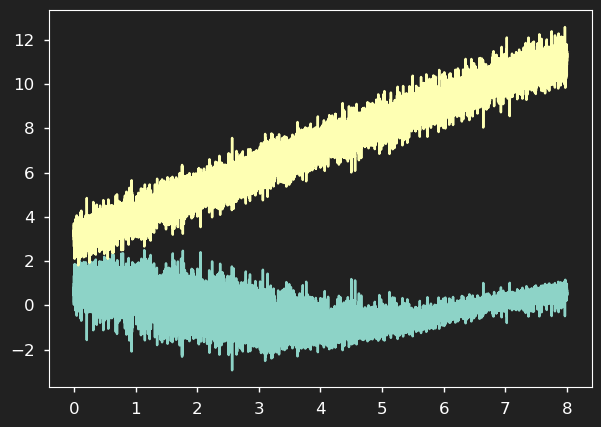

In [20]:
Fpath = fwdF(path.T).T
plt.plot(sol_lin.t, Fpath.T[1])
plt.plot(sol_lin.t, Fpath.T[0]);

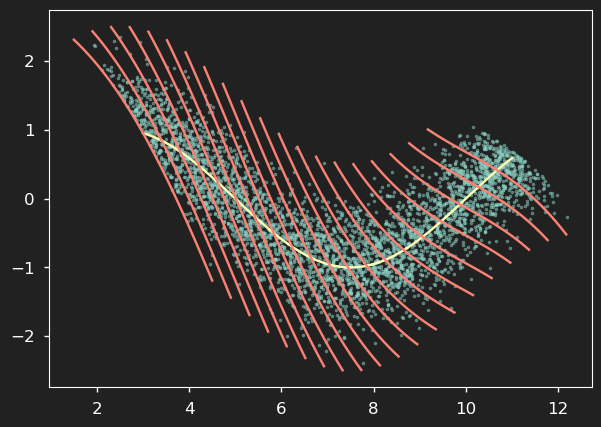

In [21]:
# plt.figure(figsize=(10,7))
plt.scatter(*Fdata.T, alpha=.5, s=5);
u = np.linspace(3, 11, 100)
spine = F(u, u)
plt.plot(*spine, c='C1');

fibers = []
for u0 in u[::5]:
    v = np.linspace(u0-1.5, u0+1.5, 50)
    fibers.append(F(u0, v))
    plt.plot(*F(u0, v), color='C3')

## Transformation of underlying SDE

In [22]:
Fens0 = fwdF(ens0.T).T

### Direct formulas

In [23]:
def drift_Flin(t, x, dx):
    dx[0] = (x[1]-np.sin(x[0]/2)) / eps
    dx[1] = (.5*np.cos(x[0]/2)-1)*(x[1]-np.sin(x[0]/2))/eps - np.sin(x[0]/2)/(24*eps) + 1

def dispersion_Flin(t, x, dx):
    dx[0,0] = 1.0 / np.sqrt(3*eps)
    dx[1,0] = (.5*np.cos(x[0]/2) - 1) / np.sqrt(3*eps)
    dx[1,1] = .1

sde_Flin = spaths.ItoSDE(drift_Flin, dispersion_Flin, noise_mixing_dim=2)

In [24]:
sol_Fsde = em.solve(sde_Flin, Fens0, (0, 8), dt)

np.any(Fpath == np.nan) = False


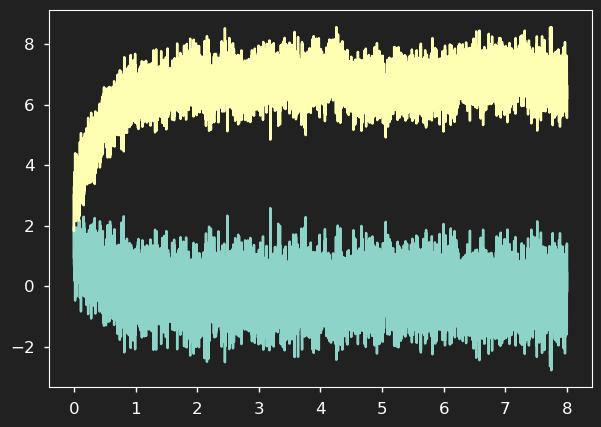

In [25]:
Ftimes = sol_Fsde.t
Fpath = sol_Fsde.p[0]
print(f"{np.any(Fpath == np.nan) = }")
plt.plot(Ftimes, Fpath.T[1])
plt.plot(Ftimes, Fpath.T[0]);

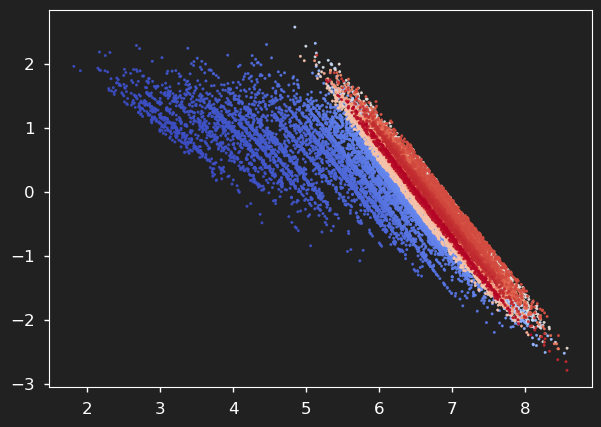

In [26]:
plt.scatter(*Fpath.T, s=3, c=Ftimes);

In [27]:
Ftransform = spaths.SDETransform(fwdF, bwdF)
Fsde_lin = Ftransform(sde_lin)

In [28]:
sol_Fsde = em.solve(Fsde_lin, Fens0, (0, 4), dt/2)

np.any(Fpath == np.nan) = False


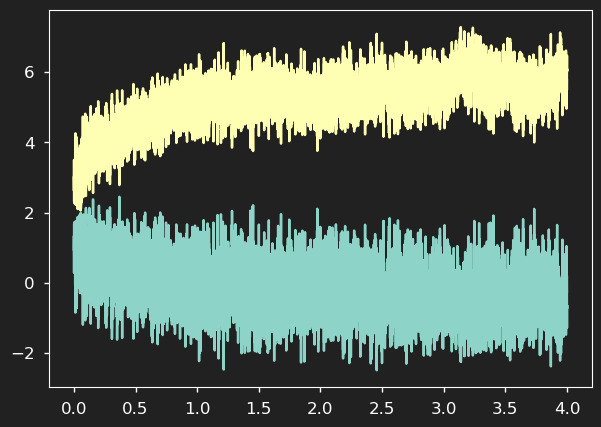

In [29]:
Ftimes = sol_Fsde.t
Fpath = sol_Fsde.p[0]
print(f"{np.any(Fpath == np.nan) = }")
plt.plot(Ftimes, Fpath.T[1])
plt.plot(Ftimes, Fpath.T[0]);

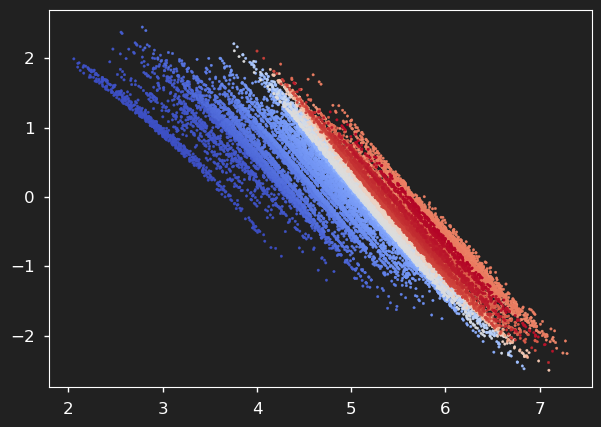

In [30]:
plt.scatter(*Fpath.T, s=3, c=Ftimes);

In [31]:
Fdata = path[1::10].astype(np.float32)
Fdata = rng.permutation(Fdata)  # results do not depend on time relation
print(f"{Fdata.shape = }")
print(f"{Fdata.dtype = }")

Fdata.shape = (4000, 2)
Fdata.dtype = dtype('float32')


### A glimpse on a slow map

In [32]:
rind = rng.integers(len(Fdata))
start = [Fdata[rind]]

test_sol = em.solve(Fsde_lin, start, (0, 1), dt)

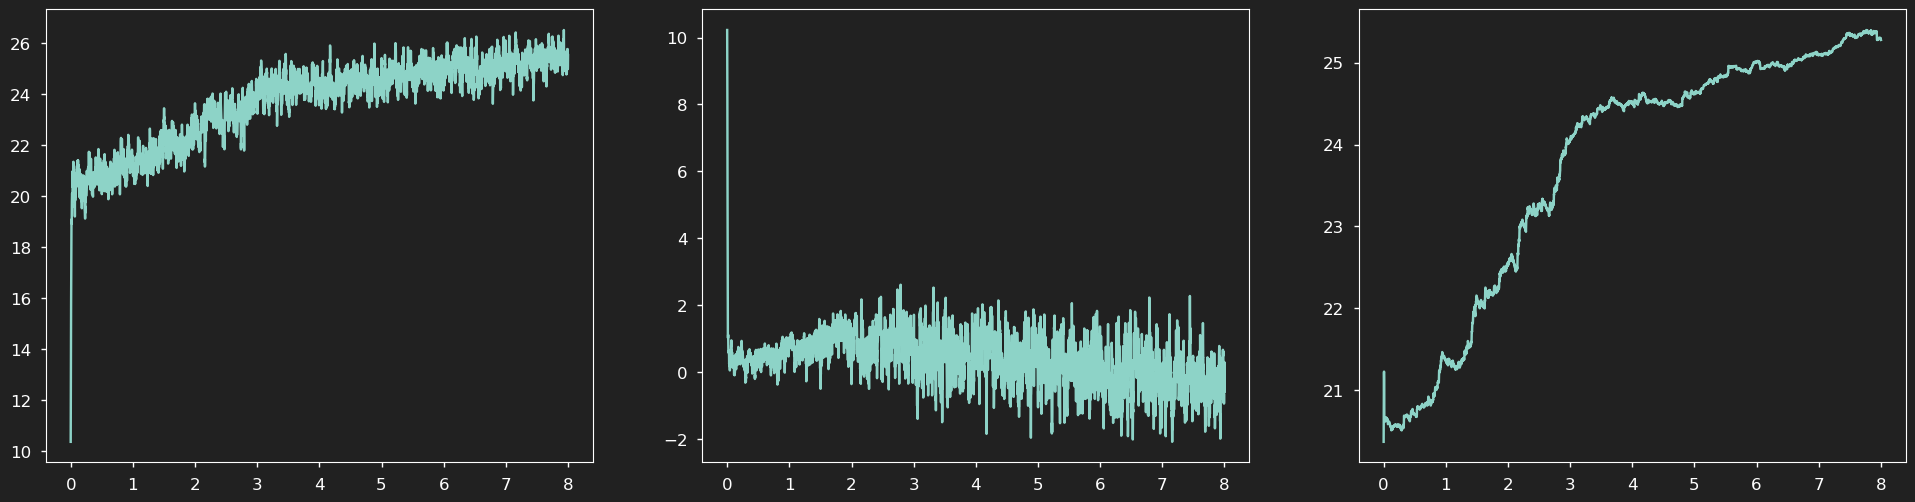

In [33]:
test_path = test_sol.p[0].T
t = np.linspace(*tspan, len(test_path.T))

fig, axs = plt.subplots(ncols=3, figsize=(24,6), sharex=True)

axs[0].plot(t, test_path[0])
axs[1].plot(t, test_path[1])

axs[2].plot(t, G(*test_path)[0])

plt.show()

# Normalization

In [146]:
means = jnp.mean(Fdata, axis=0)
stds = jnp.std(Fdata, axis=0)

In [147]:
# Z normalization
fwdZ = lambda x: jnp.array([(x[0] - means[0]) / stds[0], (x[1] - means[1]) / stds[1]])
bwdZ = lambda y: jnp.array([stds[0] * y[0] + means[0], stds[1] * y[1] + means[1]])

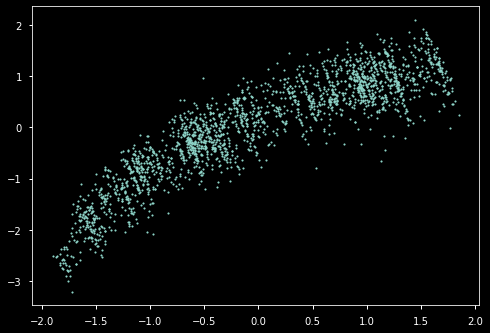

In [148]:
plt.scatter(*fwdZ(Fdata.T), s=3);

### Testing `jax` autodiff

In [149]:
from jax import jit, vmap, jacfwd

In [150]:
jax_fwdZ = jit(fwdZ)
jax_dfwdZ = jit(vmap(jacfwd(fwdZ), in_axes=1, out_axes=2))

In [151]:
batch = Fdata[:10]

In [152]:
jax_fwdZ(batch.T).shape

(2, 10)

In [153]:
jax_dfwdZ(batch.T).shape  # should give len(batch) 2 by 2 matrices

(2, 2, 10)

## Normalizing the observed SDE

In [154]:
Ztransform = spaths.SDETransform(fwdZ, bwdZ)

In [155]:
ZF_sde_lin = Ztransform(Fsde_lin)

In [156]:
ZFens0 = fwdZ(Fens0.T).T
sol_ZFsde = em.solve(ZF_sde_lin, ZFens0, tspan, dt)

np.any(path == np.nan) = False


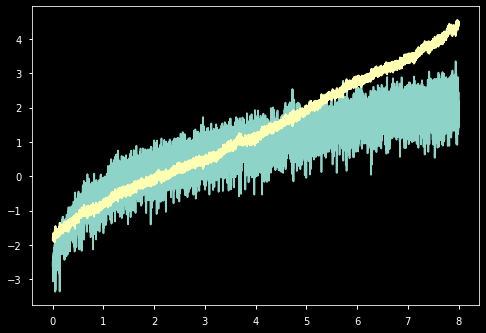

In [157]:
times = sol_ZFsde.t
path = sol_ZFsde.p[0]
print(f"{np.any(path == np.nan) = }")
plt.plot(times, path.T[1])
plt.plot(times, path.T[0]);

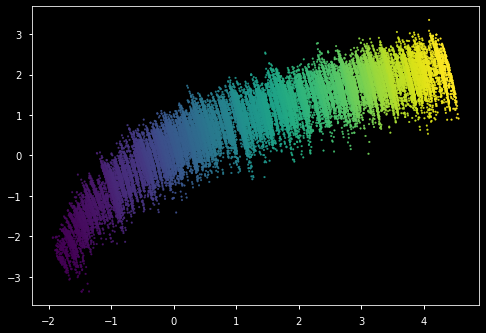

In [158]:
plt.scatter(*path.T, s=3, c=times);

In [159]:
Zdata = path[1::10].astype(np.float32)
Zdata = rng.permutation(Zdata)  # results do not depend on time relation
print(f"{Zdata.shape = }")
print(f"{Zdata.dtype = }")

Zdata.shape = (4000, 2)
Zdata.dtype = dtype('float32')


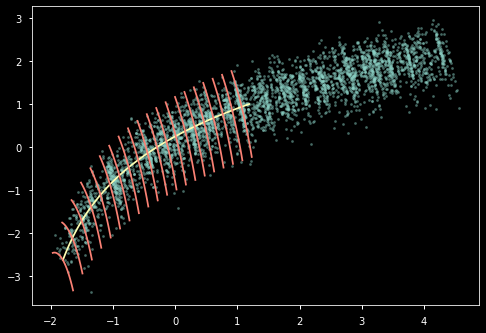

In [161]:
# plt.figure(figsize=(10,7))
plt.scatter(*Zdata.T, alpha=.5, s=5);
u = np.linspace(3, 25, 100)
Zspine = fwdZ(F(u, u))
plt.plot(*Zspine, c='C1');

Zfibers = []
for u0 in u[::5]:
    v = np.linspace(u0-1.2, u0+1.2, 50)
    Zfibers.append(fwdZ(F(u0, v)))
    plt.plot(*Zfibers[-1], color='C3')

# Sampling fibers and slow manifold

## Short trajectories along fibers

In [41]:
ends = np.array([fib.T[10*(-1)**n] for n, fib in enumerate(Zfibers)])

In [42]:
sol_Zfibers = em.solve(ZF_sde_lin, ends, (0, 1), dt)

In [43]:
sol_Zfibers.p.shape

(20, 5002, 2)

In [1]:
fig, axs = plt.subplots(nrows=3, figsize=(6,12), sharex=True)

for n, ax in enumerate(axs):
    
    ax.plot(*Zspine, alpha=.5)
    for path, fib in zip(sol_Zfibers.p, Zfibers):
        ax.plot(*fib, color='C3')
        stop = int(len(path)/(10**len(axs)))*10**(n+1)
        ax.scatter(*path[:stop].T, c='C4', s=7)

fig.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## Sampling slow manifold

In [45]:
nrep = 250
ens0 = np.repeat(ends, nrep, axis=0)

In [46]:
ens0_rep = np.repeat(ends[:,np.newaxis,:], nrep, axis=1)
ens0_rep.shape

(20, 250, 2)

In [47]:
Zbursts = em.burst(ZF_sde_lin, ens0, (0, 100), dt).reshape(len(ends), nrep, 2)
Zbursts.shape

(20, 250, 2)

In [49]:
slow_means = np.nanmean(Zbursts, axis=1)
slow_means.shape

(20, 2)

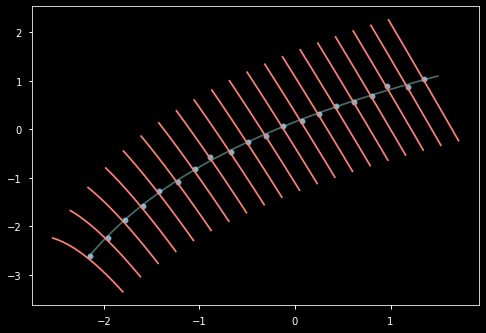

In [50]:
plt.plot(*Zspine, alpha=.5)
for fib in Zfibers:
    plt.plot(*fib, color='C3')
plt.scatter(*slow_means.T, c='C4', s=30)

plt.show()

In [51]:
ens0 = np.repeat(Zdata, nrep, axis=0)

In [52]:
Zbursts = em.burst(ZF_sde_lin, ens0, (0, 10), dt).reshape(len(Fdata), nrep, 2)
Zbursts.shape

(4000, 250, 2)

In [53]:
slow_means = np.nanmean(Zbursts, axis=1)
slow_means.shape

(4000, 2)

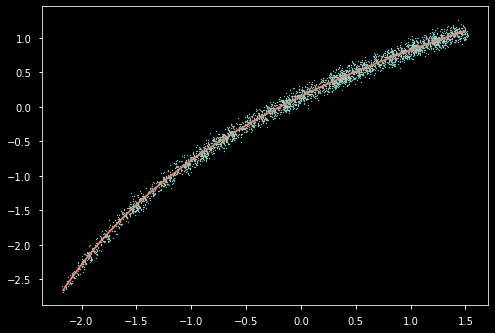

In [54]:
plt.plot(*Zspine, c='C3')
plt.scatter(*slow_means.T, s=1)
plt.show()

# Local noise covariances

## LNCs at data point

In [55]:
# local noise covaraiances of sde at the data points
ln_covs = dmaps.lnc_ito(Zdata, ZF_sde_lin)

In [56]:
e_vals, e_vecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*...) is equiv to transposing :)

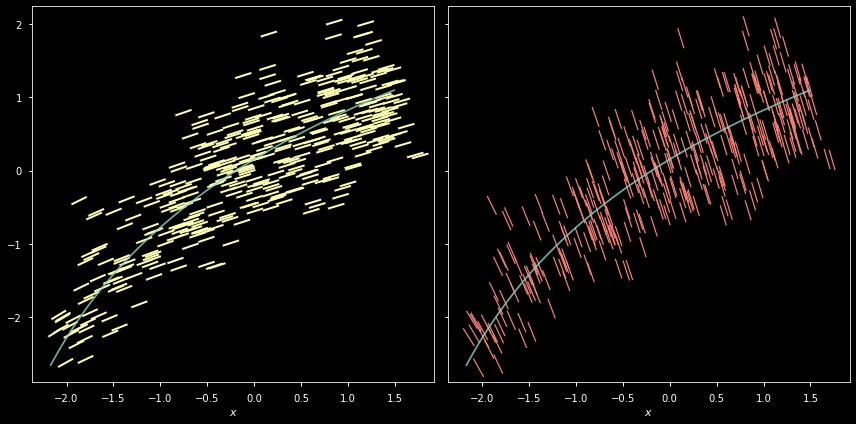

In [72]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=True)

step = 10
X, Y = Zdata[::step].T
XS, YS = zip(*[e_vec[:,0] for e_vec in e_vecs[::step]])
XF, YF = zip(*[e_vec[:,1] for e_vec in e_vecs[::step]])

axs[0].quiver(X, Y, XS, YS, pivot="middle", width=0.005, headwidth=0, scale=15, color='C1')
axs[1].quiver(X, Y, XF, YF, pivot="middle", width=0.003, headwidth=0, scale=15, color='C3')
# for d, e_vec in zip(data[:1000], e_vecs):
# #     print(d)
#     plt.quiver(*d, *e_vec[:,0], pivot="middle", width=0.003, scale=50)

for ax in axs:
    ax.plot(*Zspine, alpha=.8)
#     ax.set_xlim([-1, 1])
#     ax.set_xticks([-1, 1])
#     ax.set_ylim([-1, 1])
#     ax.set_yticks([-1, 1])
#     ax.set_aspect("equal")
    ax.set_xlabel("$x$")
#     ax.set_ylabel("$y$", rotation=0)

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## LNCs on fibers

In [58]:
ens = np.vstack([fib.T[::5] for fib in fibers])
print(f"{ens.shape = }")
# local noise covaraiances of sde at the data points
ln_covs = dmaps.lnc_ito(ens, ZF_sde_lin)

# nsam = 10**5
# ln_covs = dmaps.ln_covs(ens, sde_Fou, em, nsam, dt)

ens.shape = (200, 2)


In [59]:
ln_prcs = [np.linalg.pinv(cov) for cov in ln_covs]

In [60]:
lnc_evals, lnc_evecs = zip(*[np.linalg.eigh(cov) for cov in ln_covs])  # zip(*...) is equiv to transposing :)

In [61]:
lnp_evals, lnp_evecs = zip(*[np.linalg.eigh(pre) for pre in ln_prcs])

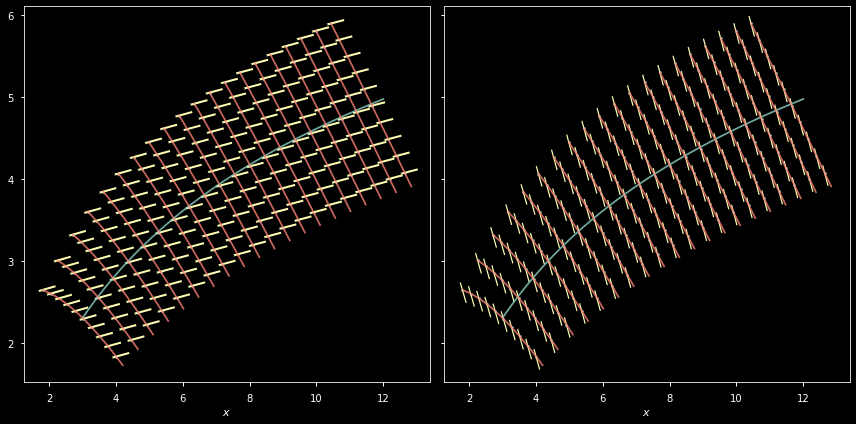

In [62]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6), sharey=True)

step = 10
X, Y = ens.T

XS, YS = np.array([e_vec[:,0] for e_vec in lnc_evecs]).T
XF, YF = np.array([e_vec[:,1] for e_vec in lnc_evecs]).T
# XS, YS = zip(*[e_vec[:,1] for e_vec in lnp_evecs])
# XF, YF = zip(*[e_vec[:,0] for e_vec in lnp_evecs])

# axs[0].quiver(X, Y, XS, YS, pivot="middle", width=0.005, headwidth=0, scale=15, color='C1')
# axs[1].quiver(X, Y, XF, YF, pivot="middle", width=0.003, headwidth=0, scale=15, color='C3')
# for d, e_vec in zip(data[:1000], e_vecs):
# #     print(d)
#     plt.quiver(*d, *e_vec[:,0], pivot="middle", width=0.003, scale=50)

for ax in axs:
    ax.plot(*spine, alpha=.8)
    for fib in fibers:
        ax.plot(*fib, c='C3', alpha=.8)
    ax.scatter(*ens.T, s=5)
#     ax.set_xlim([-1, 1])
#     ax.set_xticks([-1, 1])
#     ax.set_ylim([-1, 1])
#     ax.set_yticks([-1, 1])
#     ax.set_aspect("equal")
    ax.set_xlabel("$x$")
#     ax.set_ylabel("$y$", rotation=0)

axs[0].quiver(X, Y, XS, YS, pivot="middle", width=0.005, headwidth=0, scale=15, color='C1')
axs[1].quiver(X, Y, XF, YF, pivot="middle", width=0.003, headwidth=0, scale=15, color='C1')

fig.tight_layout()
plt.show(fig)
plt.close(fig)

## Data affinity

In [63]:
npts = 10
u = np.linspace(6, 10, npts)
slow = np.array(fwdZ(F(u, u))).T

u0 = np.mean(u)
v = np.linspace(u0-1, u0+1, npts+1)
fast = np.array(fwdZ(F(u0, v))).T

In [64]:
ens = np.vstack([slow, fast])

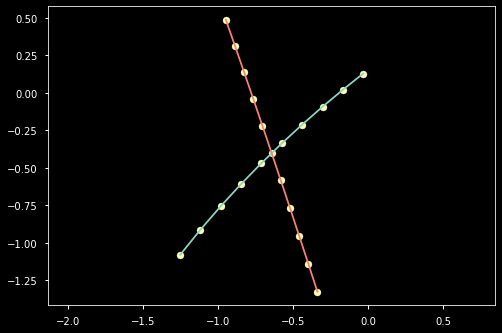

In [65]:
plt.plot(*slow.T)
plt.plot(*fast.T, c='C3')
plt.scatter(*ens.T, c='C1')

plt.axis('equal')
plt.show()

In [66]:
ln_covs = dmaps.lnc_ito(ens, ZF_sde_lin)
ln_prcs = [np.linalg.pinv(cov) for cov in ln_covs]
id_covs = (np.eye(2)[..., None] * np.ones(len(ens))).T

In [67]:
eps = 5

In [68]:
aff_id = dmaps.data_affinity(ens, id_covs, eps)

Computing affinity matrix for epsilon = 5 


In [69]:
aff_ln = dmaps.data_affinity(ens, ln_covs, eps)

Computing affinity matrix for epsilon = 5 


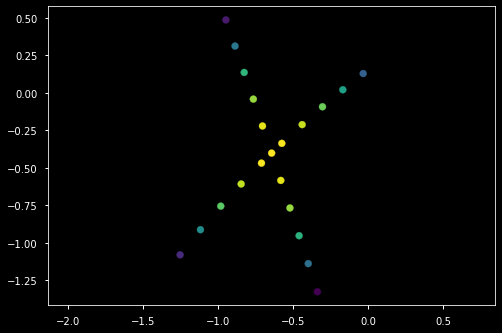

In [70]:
plt.scatter(*ens.T, c=aff_id[-6])

plt.axis('equal')
plt.show()

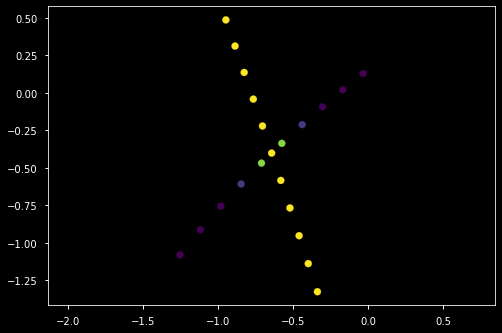

In [71]:
plt.scatter(*ens.T, c=aff_ln[-6])

plt.axis('equal')
plt.show()